In [1]:
# Import các thư viện cần thiết
from sklearn.cluster import MiniBatchKMeans
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt
import cv2
from glob import glob
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
import random
import warnings
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
warnings.filterwarnings("ignore")

In [2]:
# Đường dẫn chính xác đến thư mục dữ liệu
data_dir = '/kaggle/input/brain-tumor-mri-dataset'

# Tìm tất cả các ảnh trong thư mục Training
image_paths = glob(os.path.join(data_dir, 'Training/*/*.jpg'))

# Kiểm tra xem đã tìm thấy ảnh hay chưa
if len(image_paths) == 0:
    raise ValueError(f"Không tìm thấy ảnh trong {data_dir}. Vui lòng kiểm tra lại đường dẫn và định dạng tệp.")

# In số lượng ảnh
print(f"Số lượng ảnh tìm thấy: {len(image_paths)}")


Số lượng ảnh tìm thấy: 5712


In [3]:
# Chọn một ảnh ngẫu nhiên để kiểm tra
random_image_path = random.choice(image_paths)
img = cv2.imread(random_image_path)

if img is None:
    raise ValueError(f"Không thể đọc ảnh từ đường dẫn: {random_image_path}")

print(f"Path: {random_image_path}")
print(f"Shape of the image: {img.shape}")

Path: /kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-gl_0504.jpg
Shape of the image: (512, 512, 3)


In [4]:
def process_image_pillow(path):
    try:
        with Image.open(path) as img:
            img = img.convert('RGB')  # Đảm bảo 3 kênh RGB
            img = img.resize((128, 128))
            return np.array(img)
    except Exception as e:
        print(f"Cảnh báo: Không thể đọc ảnh từ đường dẫn: {path}. Lỗi: {e}")
        return None

In [5]:
    # Sử dụng ThreadPoolExecutor để xử lý ảnh song song
    images = []
    with ThreadPoolExecutor(max_workers=16) as executor:
        results = list(tqdm(executor.map(process_image_pillow, image_paths), total=len(image_paths), desc="Processing images"))
    
    # Loại bỏ các giá trị None
    images = [img for img in results if img is not None]
    
    # Kiểm tra xem tất cả các ảnh đều có cùng kích thước và số kênh
    consistent = all(img.shape == images[0].shape for img in images)
    if not consistent:
        raise ValueError("Các ảnh không có kích thước hoặc số kênh đồng nhất.")
    
    # Chuyển đổi danh sách thành mảng numpy
    data = np.array(images)
    
    # Kiểm tra số lượng ảnh đã nạp và shape của dữ liệu
    print(f"Số lượng ảnh đã nạp: {len(images)}")
    print(f"Shape của dữ liệu: {data.shape}")


Processing images: 100%|██████████| 5712/5712 [00:11<00:00, 490.19it/s]


Số lượng ảnh đã nạp: 5712
Shape của dữ liệu: (5712, 128, 128, 3)


20 Pixel Ngẫu Nhiên:
Tọa độ (X, Y): (65, 115), Giá trị Pixel (RGB): [27 27 27]
Tọa độ (X, Y): (55, 108), Giá trị Pixel (RGB): [33 33 33]
Tọa độ (X, Y): (41, 27), Giá trị Pixel (RGB): [45 45 45]
Tọa độ (X, Y): (18, 120), Giá trị Pixel (RGB): [53 53 53]
Tọa độ (X, Y): (80, 3), Giá trị Pixel (RGB): [1 1 1]
Tọa độ (X, Y): (25, 93), Giá trị Pixel (RGB): [47 47 47]
Tọa độ (X, Y): (41, 125), Giá trị Pixel (RGB): [9 9 9]
Tọa độ (X, Y): (87, 101), Giá trị Pixel (RGB): [46 46 46]
Tọa độ (X, Y): (107, 16), Giá trị Pixel (RGB): [3 3 3]
Tọa độ (X, Y): (58, 17), Giá trị Pixel (RGB): [21 21 21]
Tọa độ (X, Y): (66, 74), Giá trị Pixel (RGB): [66 66 66]
Tọa độ (X, Y): (124, 101), Giá trị Pixel (RGB): [0 0 0]
Tọa độ (X, Y): (11, 53), Giá trị Pixel (RGB): [0 0 0]
Tọa độ (X, Y): (114, 38), Giá trị Pixel (RGB): [0 0 0]
Tọa độ (X, Y): (73, 24), Giá trị Pixel (RGB): [45 45 45]
Tọa độ (X, Y): (112, 54), Giá trị Pixel (RGB): [0 0 0]
Tọa độ (X, Y): (27, 76), Giá trị Pixel (RGB): [69 69 69]
Tọa độ (X, Y): (96, 73

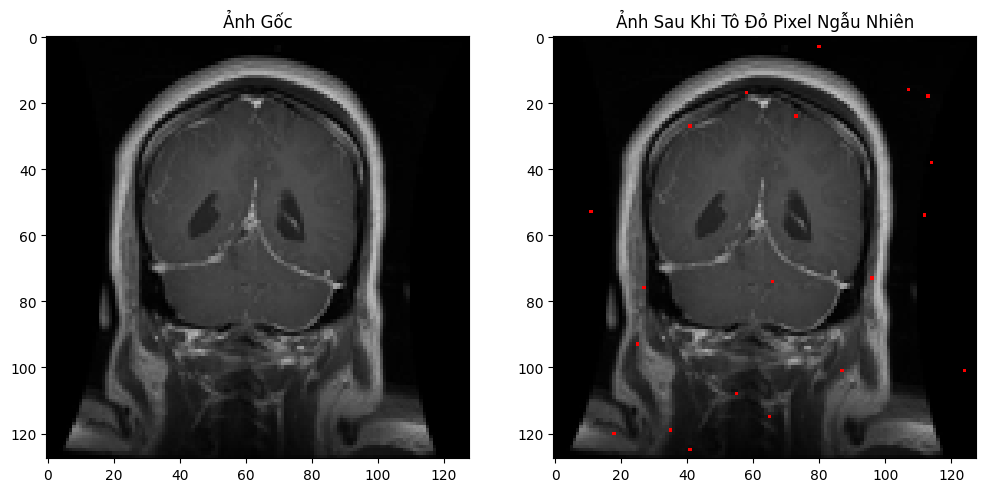

In [6]:
# Chọn một ảnh bất kỳ từ tập dữ liệu
random_image = random.choice(data)  # Chọn ảnh ngẫu nhiên từ dữ liệu đã xử lý
height, width, _ = random_image.shape

# Truy xuất 20 pixel ngẫu nhiên
all_coordinates = [(x, y) for y in range(height) for x in range(width)]
random_coordinates = random.sample(all_coordinates, 20)

# In tọa độ và giá trị pixel của 20 pixel ngẫu nhiên
print("20 Pixel Ngẫu Nhiên:")
for coord in random_coordinates:
    x, y = coord
    pixel_value = random_image[y, x]  # Lấy giá trị pixel
    print(f"Tọa độ (X, Y): ({x}, {y}), Giá trị Pixel (RGB): {pixel_value}")

# Tô màu đỏ (RGB: [255, 0, 0]) cho các pixel này trên ảnh gốc
highlighted_image = random_image.copy()
for coord in random_coordinates:
    x, y = coord
    highlighted_image[y, x] = [255, 0, 0]  # Tô màu đỏ

# Hiển thị ảnh gốc và ảnh đã được tô màu
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Ảnh gốc
axs[0].imshow(random_image)
axs[0].set_title("Ảnh Gốc")
axs[0].axis("on")

# Ảnh với pixel tô màu đỏ
axs[1].imshow(highlighted_image)
axs[1].set_title("Ảnh Sau Khi Tô Đỏ Pixel Ngẫu Nhiên")
axs[1].axis("on")

plt.show()


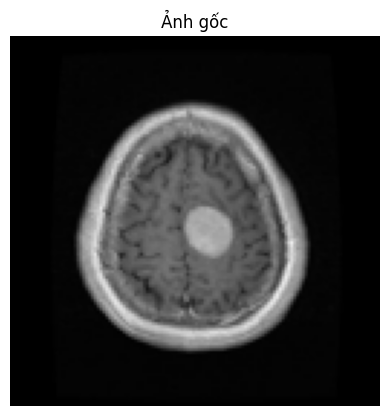

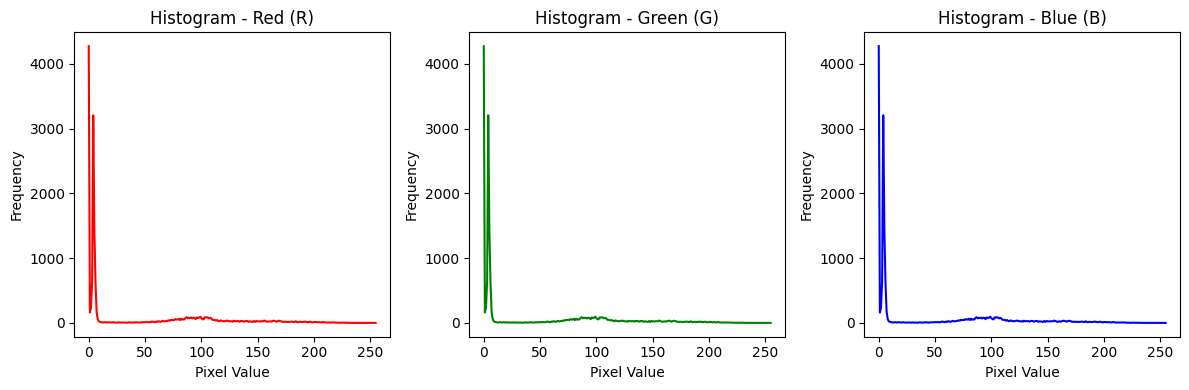

In [7]:
def plot_rgb_histogram(image):
    """
    Vẽ biểu đồ histogram cho các kênh màu R, G, B.
    """
    # Tách các kênh R, G, B
    r_channel = image[:, :, 0]
    g_channel = image[:, :, 1]
    b_channel = image[:, :, 2]

    # Tính histogram cho từng kênh
    hist_r = cv2.calcHist([r_channel], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([g_channel], [0], None, [256], [0, 256])
    hist_b = cv2.calcHist([b_channel], [0], None, [256], [0, 256])

    # Vẽ biểu đồ cho từng kênh
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(hist_r, color='red')
    plt.title("Histogram - Red (R)")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    plt.subplot(1, 3, 2)
    plt.plot(hist_g, color='green')
    plt.title("Histogram - Green (G)")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    plt.subplot(1, 3, 3)
    plt.plot(hist_b, color='blue')
    plt.title("Histogram - Blue (B)")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Lấy một ảnh từ dataset
random_image = random.choice(data)

# Hiển thị ảnh gốc
plt.imshow(random_image)
plt.title("Ảnh gốc")
plt.axis('off')
plt.show()

# Hiển thị histogram của ảnh trong không gian RGB
plot_rgb_histogram(random_image)


### **Trích xuất đặc trưng và nhận xét về biểu đồ Histogram trong không gian RGB**

Từ hình ảnh và biểu đồ histogram, có một số nhận xét như sau:

---

#### **1. Ảnh gốc:**
- Ảnh gốc là một ảnh MRI chủ yếu nằm trong thang độ xám (**grayscale**), tức là tất cả các kênh **Red (R)**, **Green (G)** và **Blue (B)** có phân bố pixel gần giống nhau.

---

#### **2. Biểu đồ Histogram:**
Histogram cho mỗi kênh **Red (R)**, **Green (G)** và **Blue (B)** có những đặc điểm sau:

1. **Kênh Red (R)**:
   - Phân bố giá trị pixel tập trung chủ yếu ở khu vực **giá trị thấp (0-50)**.
   - Một số pixel ở vùng sáng có giá trị cao hơn, nhưng tần suất thấp.
   - Điều này cho thấy rằng ảnh có nhiều vùng tối và chỉ một số vùng sáng hơn liên quan đến cấu trúc bên trong ảnh MRI.

2. **Kênh Green (G)**:
   - Có phân bố tương tự như kênh Red.
   - Giá trị pixel cao (trên 100) xuất hiện ít, cho thấy rằng hầu hết các vùng trong ảnh vẫn mang độ sáng trung bình hoặc tối.

3. **Kênh Blue (B)**:
   - Phân bố tương tự với hai kênh còn lại (Red và Green).
   - Điều này phù hợp với nhận xét rằng ảnh này là **grayscale**, nơi tất cả các kênh màu đều có cùng giá trị.

---

#### **3. Nhận xét tổng quát:**
- Vì ảnh là MRI (grayscale), các kênh **R**, **G**, và **B** có phân bố tương tự.
- Phân bố pixel chủ yếu tập trung ở vùng giá trị thấp (tối), với một vài vùng sáng hơn (trong não hoặc vùng trắng trong ảnh MRI).
- Điều này cho thấy ảnh chứa nhiều vùng tối (vùng nền hoặc cấu trúc ít quan trọng) và một số vùng sáng (vùng cấu trúc quan trọng trong não, như khối u hoặc tổn thương).

---

### **Ứng dụng của nhận xét này:**
- **Phân tích vùng sáng/tối:** Histogram cho thấy rõ ràng sự phân bố sáng tối, giúp xác định các vùng sáng (thường là vùng quan trọng như tổn thương hoặc khối u) trong ảnh.
- **Tiền xử lý:** Nếu cần làm nổi bật các vùng sáng, có thể áp dụng các kỹ thuật như tăng cường độ sáng (Contrast Enhancement) hoặc cân bằng histogram (Histogram Equalization).

In [8]:
def apply_kmeans_highlight_tumor(image, K=5):
    """
    Áp dụng K-means clustering để xác định cụm chứa khối u và tô màu đỏ cho cụm đó.

    Parameters:
    - image: Ảnh gốc dưới dạng numpy array với shape (128, 128, 3).
    - K: Số cụm màu cần phân loại.

    Returns:
    - new_image: Ảnh sau khi đã tô màu đỏ cho cụm chứa khối u với shape (128, 128, 3).
    """
    # Reshape ảnh thành mảng 2D (số lượng pixel, 3)
    pixels = image.reshape(-1, 3)

    # Áp dụng MiniBatchKMeans
    kmeans = MiniBatchKMeans(n_clusters=K, random_state=42, batch_size=1000)
    kmeans.fit(pixels)

    # Lấy các centroid và tính độ sáng trung bình của mỗi centroid
    centroids = kmeans.cluster_centers_
    brightness = np.sum(centroids, axis=1)  # Tổng các giá trị RGB làm độ sáng
    # Giả định cụm có độ sáng trung bình cao nhất chứa khối u
    tumor_cluster = np.argmax(brightness)

    # Tạo bản đồ màu mới: chỉ tô đỏ cho cụm chứa khối u
    new_pixels = pixels.copy()
    # Tô màu đỏ (255, 0, 0) cho các pixel thuộc cụm chứa khối u
    new_pixels[kmeans.labels_ == tumor_cluster] = [255, 0, 0]

    # Reshape trở lại kích thước ban đầu của ảnh
    new_image = new_pixels.reshape(image.shape)

    return new_image


In [9]:
# Các giá trị K từ 2 đến 5
K_values = [2, 3, 4, 5]
data_kmeans_highlighted = {}

for K in K_values:
    print(f"Đang áp dụng KMeans với K={K} và tô màu đỏ cho cụm u...")
    processed_images = []
    for img in tqdm(data, desc=f"K={K}"):
        processed_img = apply_kmeans_highlight_tumor(img, K)
        processed_images.append(processed_img)
    data_kmeans_highlighted[K] = np.array(processed_images)
    print(f"Hoàn thành K={K}.")


Đang áp dụng KMeans với K=2 và tô màu đỏ cho cụm u...


K=2: 100%|██████████| 5712/5712 [01:38<00:00, 58.03it/s]


Hoàn thành K=2.
Đang áp dụng KMeans với K=3 và tô màu đỏ cho cụm u...


K=3: 100%|██████████| 5712/5712 [01:48<00:00, 52.63it/s]


Hoàn thành K=3.
Đang áp dụng KMeans với K=4 và tô màu đỏ cho cụm u...


K=4: 100%|██████████| 5712/5712 [01:55<00:00, 49.54it/s]


Hoàn thành K=4.
Đang áp dụng KMeans với K=5 và tô màu đỏ cho cụm u...


K=5: 100%|██████████| 5712/5712 [02:05<00:00, 45.52it/s]


Hoàn thành K=5.


In [10]:
def display_sample_images(original, processed_dict, sample_indices, K_values=[2,3,4,5]):
    """
    Hiển thị các ảnh gốc và ảnh đã qua K-means bên cạnh nhau cho các giá trị K khác nhau.

    Parameters:
    - original: Mảng chứa các ảnh gốc với shape (num_images, 128, 128, 3).
    - processed_dict: Từ điển chứa các ảnh đã qua K-means với các K khác nhau.
    - sample_indices: Danh sách các chỉ số của ảnh mẫu để hiển thị.
    - K_values: Danh sách các giá trị K đã sử dụng trong K-means.
    """
    num_samples = len(sample_indices)
    num_K = len(K_values)

    # Tạo subplot với num_samples hàng và (1 + num_K) cột
    fig, axs = plt.subplots(num_samples, 1 + num_K, figsize=(5*(1 + num_K), 5*num_samples))

    if num_samples == 1:
        axs = [axs]  # Đảm bảo axs là list khi chỉ có một sample

    for row, idx in enumerate(sample_indices):
        # Hiển thị ảnh gốc
        axs[row][0].imshow(original[idx])
        axs[row][0].set_title("Ảnh Gốc", fontsize=12, fontweight='bold')
        axs[row][0].axis('off')

        # Hiển thị ảnh đã qua K-means cho từng K
        for col, K in enumerate(K_values):
            axs[row][col + 1].imshow(processed_dict[K][idx])
            axs[row][col + 1].set_title(f"K={K}", fontsize=12, fontweight='bold')
            axs[row][col + 1].axis('off')

    plt.tight_layout()
    plt.show()


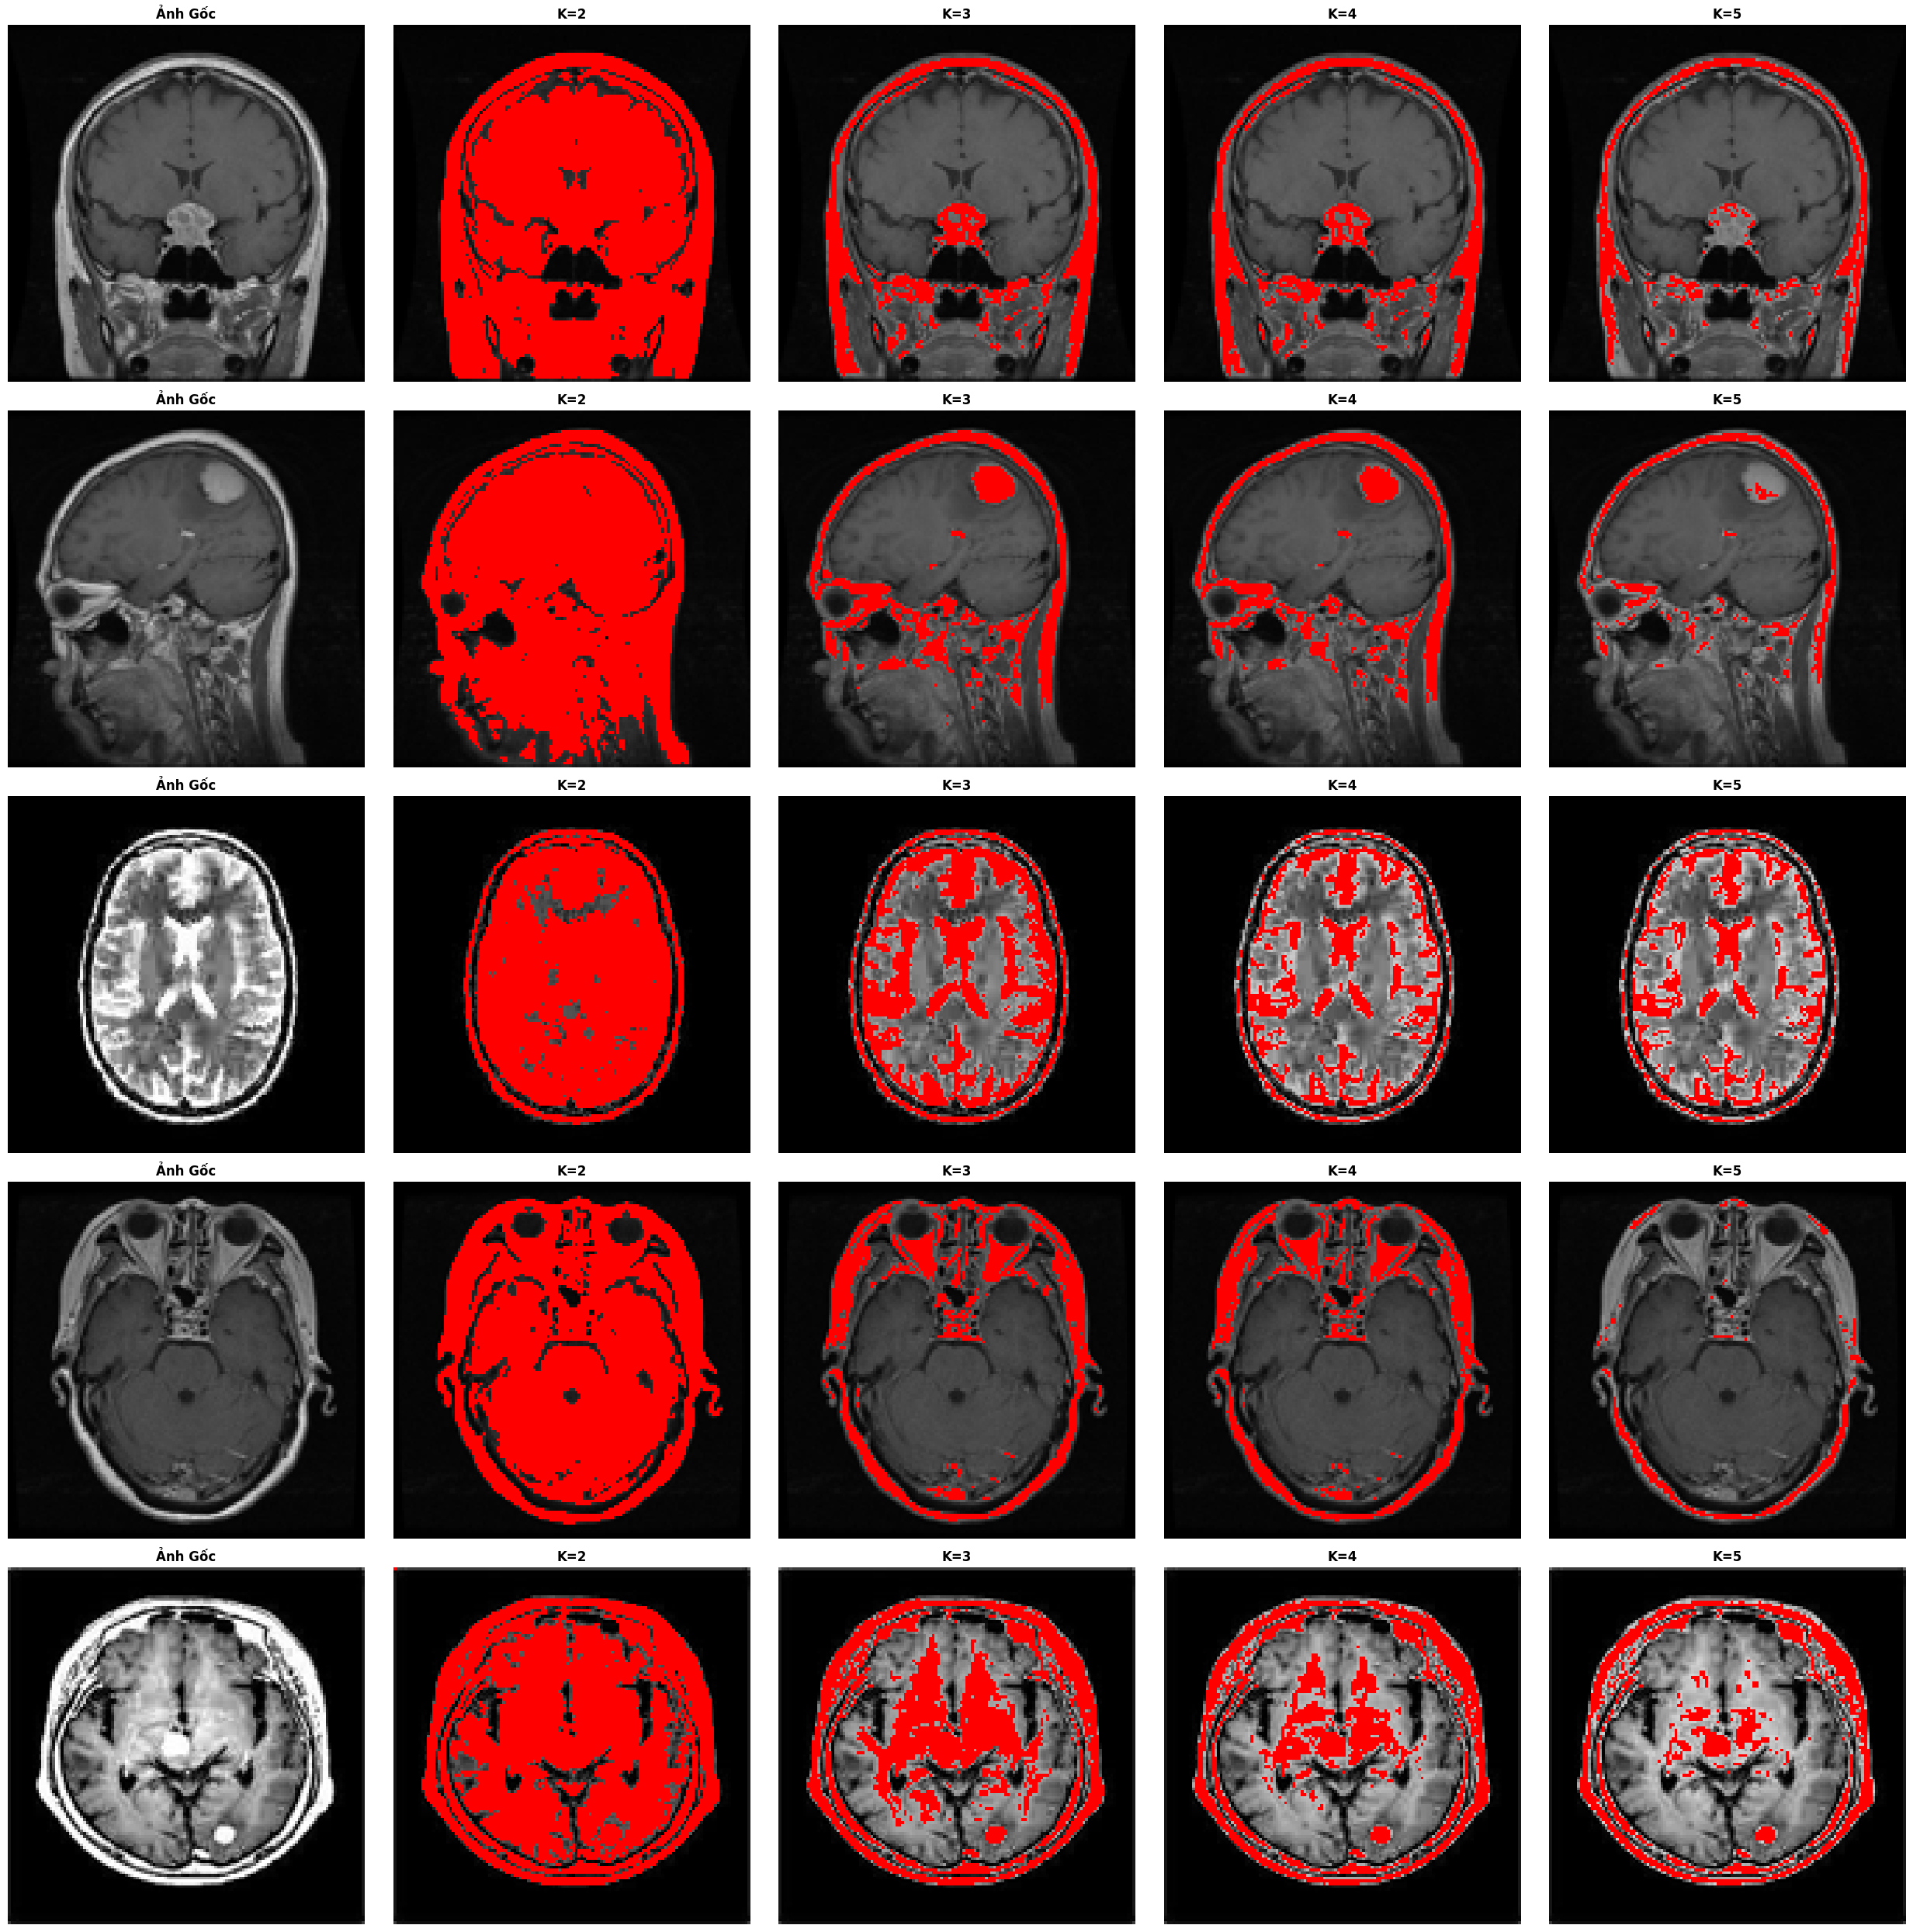

In [12]:
# Chọn ngẫu nhiên 5 ảnh để hiển thị
num_samples = 5
sample_indices = random.sample(range(len(data)), num_samples)

# Hiển thị các hình ảnh mẫu với K=2 đến K=5
display_sample_images(data, data_kmeans_highlighted, sample_indices, K_values=[2,3,4,5])


In [12]:
# Hàm áp dụng KMeans và tính các chỉ số chi phí
def apply_kmeans_and_compute_metrics_sklearn(image, K, batch_size=1000, max_iter=300):
    pixels = image.reshape(-1, 3)
    kmeans = MiniBatchKMeans(n_clusters=K, random_state=42, batch_size=batch_size, max_iter=max_iter)
    kmeans.fit(pixels)

    inertia = kmeans.inertia_
    if K >= 2:
        silhouette = silhouette_score(pixels, kmeans.labels_)
        calinski_harabasz = calinski_harabasz_score(pixels, kmeans.labels_)
        davies_bouldin = davies_bouldin_score(pixels, kmeans.labels_)
        starczewski_index = silhouette * calinski_harabasz / (davies_bouldin + 1e-6)
        wiroonsri_index = (calinski_harabasz + silhouette) / (davies_bouldin + 1e-6)
    else:
        silhouette = calinski_harabasz = davies_bouldin = starczewski_index = wiroonsri_index = None

    return {
        'Inertia': inertia,
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Index': calinski_harabasz,
        'Davies-Bouldin Index': davies_bouldin,
        'Starczewski Index': starczewski_index,
        'Wiroonsri Index': wiroonsri_index
    }

In [13]:
# Hàm tính BCVI theo phân phối Dirichlet
def compute_r_k(values, condition):
    min_value = min(values)
    max_value = max(values)
    if condition == 'A':
        return [(v - min_value) / (2 * max_value - min_value) for v in values]
    elif condition == 'B':
        sum_diff = sum(max_value - v for v in values)
        return [(max_value - v) / sum_diff for v in values]

def bcvi(values, alpha, condition):
    r_k = compute_r_k(values, condition)
    n = len(values)
    alpha_array = np.array(alpha)
    alpha_sum = np.sum(alpha_array)
    post_alpha = alpha_array + n * np.array(r_k)
    post_alpha_sum = alpha_sum + n

    p_k = post_alpha / post_alpha_sum
    return p_k

In [14]:
# Lấy ngẫu nhiên 1000 hình từ tập dữ liệu
num_samples = 1000  # Số lượng hình ảnh được lấy mẫu
if len(data) > num_samples:
    sampled_indices = np.random.choice(len(data), num_samples, replace=False)
    sampled_data = data[sampled_indices]
else:
    sampled_data = data

# Các giá trị K và alpha
K_values = list(range(2, 9))  # K từ 2 đến 8

# Thiết lập các alpha theo yêu cầu: 2, 3, 4 là small; 5, 6 là medium; 7, 8 là large
alpha_small_clusters = [25 if k in [2, 3, 4] else 2 if k in [5, 6] else 0.5 for k in K_values]
alpha_medium_clusters = [2 if k in [2, 3, 4] else 25 if k in [5, 6] else 0.5 for k in K_values]
alpha_large_clusters = [0.5 if k in [2, 3, 4] else 2 if k in [5, 6] else 25 for k in K_values]

# In alpha để kiểm tra
print("Alpha Small Clusters:", alpha_small_clusters)
print("Alpha Medium Clusters:", alpha_medium_clusters)
print("Alpha Large Clusters:", alpha_large_clusters)

Alpha Small Clusters: [25, 25, 25, 2, 2, 0.5, 0.5]
Alpha Medium Clusters: [2, 2, 2, 25, 25, 0.5, 0.5]
Alpha Large Clusters: [0.5, 0.5, 0.5, 2, 2, 25, 25]


In [15]:
# Tạo từ điển để lưu kết quả
cluster_metrics = {K: {'Inertia': [], 'Silhouette Score': [], 'Calinski-Harabasz Index': [],
                       'Davies-Bouldin Index': [], 'Starczewski Index': [], 'Wiroonsri Index': []} for K in K_values}

# Áp dụng KMeans và tính toán các chỉ số chi phí
for K in K_values:
    print(f"\nĐang áp dụng KMeans với K={K} và tính các chỉ số chi phí trên 1000 hình...")
    results = Parallel(n_jobs=-1)(
        delayed(apply_kmeans_and_compute_metrics_sklearn)(img, K) for img in tqdm(sampled_data, desc=f"K={K}")
    )
    for res in results:
        for key in cluster_metrics[K]:
            cluster_metrics[K][key].append(res[key])



Đang áp dụng KMeans với K=2 và tính các chỉ số chi phí trên 1000 hình...


K=2: 100%|██████████| 1000/1000 [20:34<00:00,  1.23s/it]



Đang áp dụng KMeans với K=3 và tính các chỉ số chi phí trên 1000 hình...


K=3: 100%|██████████| 1000/1000 [20:20<00:00,  1.22s/it]



Đang áp dụng KMeans với K=4 và tính các chỉ số chi phí trên 1000 hình...


K=4: 100%|██████████| 1000/1000 [20:03<00:00,  1.20s/it]



Đang áp dụng KMeans với K=5 và tính các chỉ số chi phí trên 1000 hình...


K=5: 100%|██████████| 1000/1000 [19:46<00:00,  1.19s/it]



Đang áp dụng KMeans với K=6 và tính các chỉ số chi phí trên 1000 hình...


K=6: 100%|██████████| 1000/1000 [19:54<00:00,  1.19s/it]



Đang áp dụng KMeans với K=7 và tính các chỉ số chi phí trên 1000 hình...


K=7: 100%|██████████| 1000/1000 [19:42<00:00,  1.18s/it]



Đang áp dụng KMeans với K=8 và tính các chỉ số chi phí trên 1000 hình...


K=8: 100%|██████████| 1000/1000 [20:11<00:00,  1.21s/it]


In [16]:
# Tính giá trị trung bình cho mỗi K
average_metrics = {K: {key: np.mean(cluster_metrics[K][key]) for key in cluster_metrics[K]} for K in K_values}

# In kết quả trung bình
print("\nKết quả trung bình các chỉ số theo K:\n")
print("{:<10} {:<15} {:<20} {:<25} {:<20} {:<20} {:<20}".format(
    "K", "Inertia", "Silhouette Score", "Calinski-Harabasz Index", 
    "Davies-Bouldin Index", "Starczewski Index", "Wiroonsri Index"
))
print("="*140)

for K in K_values:
    print("{:<10} {:<15.4f} {:<20.4f} {:<25.4f} {:<20.4f} {:<20.4f} {:<20.4f}".format(
        K,
        average_metrics[K]['Inertia'],
        average_metrics[K]['Silhouette Score'],
        average_metrics[K]['Calinski-Harabasz Index'],
        average_metrics[K]['Davies-Bouldin Index'],
        average_metrics[K]['Starczewski Index'],
        average_metrics[K]['Wiroonsri Index']
    ))



Kết quả trung bình các chỉ số theo K:

K          Inertia         Silhouette Score     Calinski-Harabasz Index   Davies-Bouldin Index Starczewski Index    Wiroonsri Index     
2          26296227.8378   0.7309               55827.0086                0.3958               125397.8447          162517.0332         
3          9880553.4971    0.7505               87155.2644                0.4260               166192.1617          214486.9216         
4          5680555.9299    0.7166               104001.0653               0.4668               166810.7235          226400.8955         
5          3603324.5415    0.7126               124717.2935               0.4769               191747.4301          263212.0241         
6          2519850.8685    0.6983               143284.2147               0.4880               210956.6441          295249.5027         
7          1880161.8028    0.6905               160727.0104               0.4928               231775.4247          328013.4429         
8

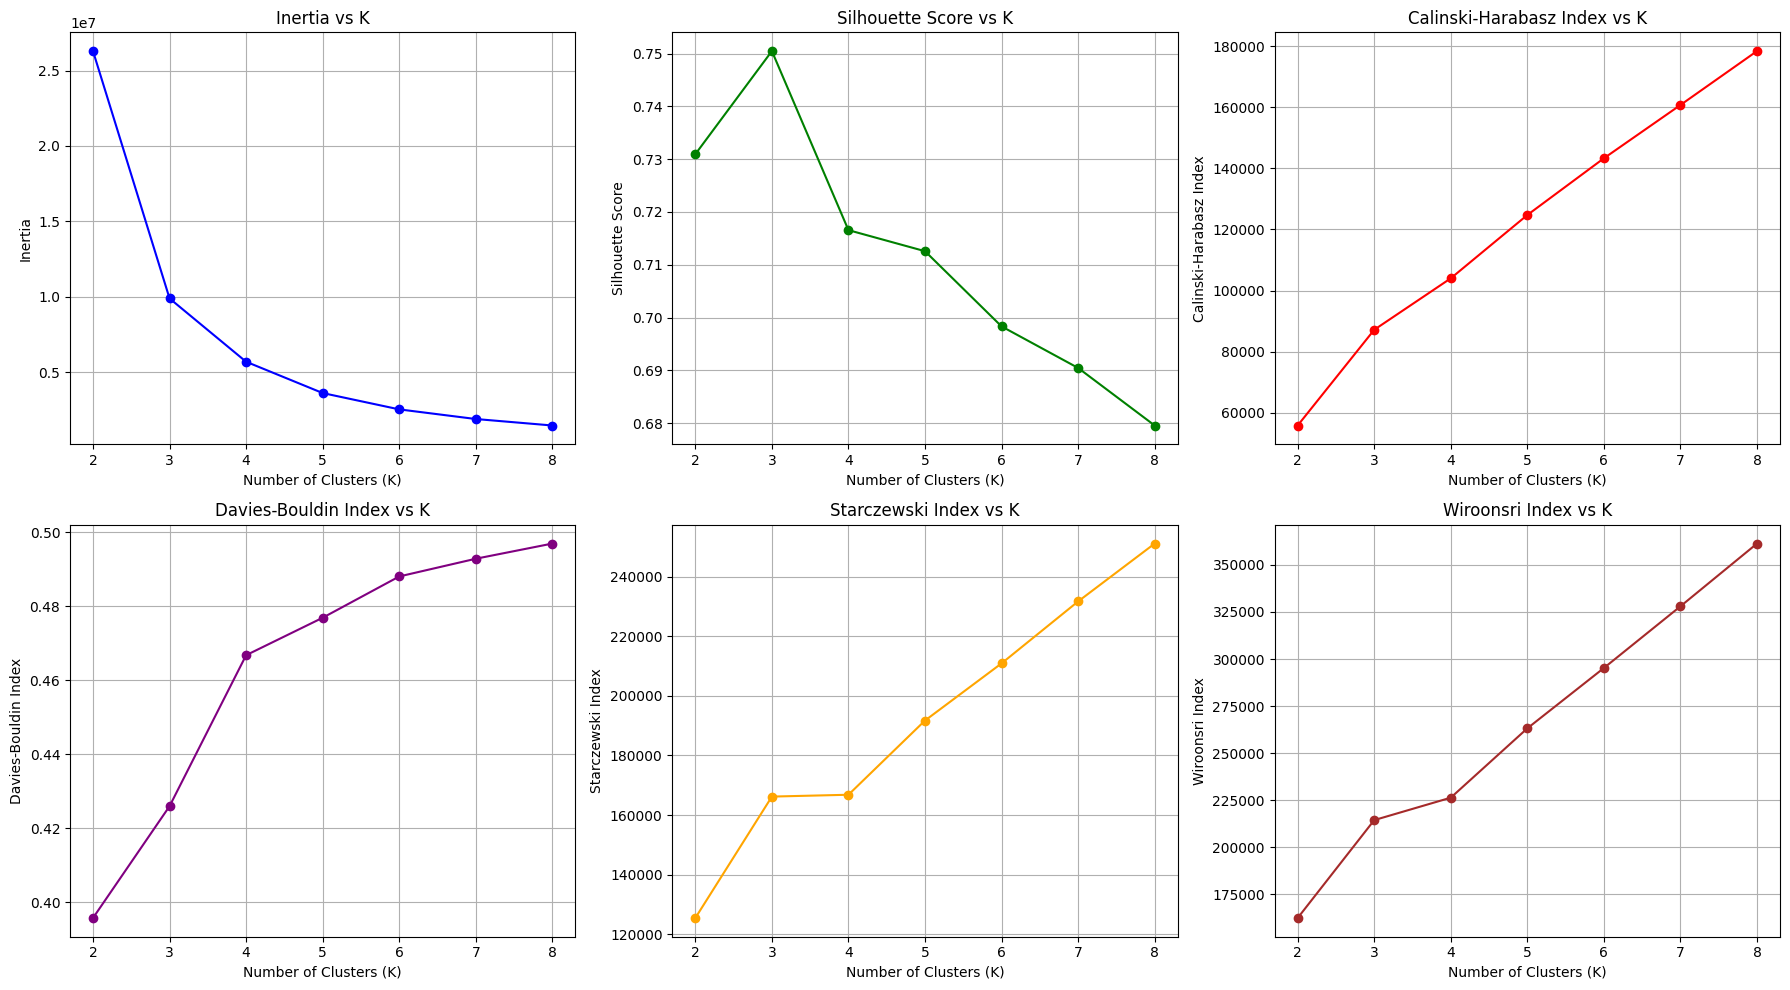

In [17]:
# Chuẩn bị dữ liệu cho đồ thị
inertia = [average_metrics[K]['Inertia'] for K in K_values]
silhouette = [average_metrics[K]['Silhouette Score'] for K in K_values]
calinski = [average_metrics[K]['Calinski-Harabasz Index'] for K in K_values]
davies = [average_metrics[K]['Davies-Bouldin Index'] for K in K_values]
starczewski = [average_metrics[K]['Starczewski Index'] for K in K_values]
wiroonsri = [average_metrics[K]['Wiroonsri Index'] for K in K_values]

# Tạo subplot với 2 hàng và 3 cột
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Inertia Plot
axs[0, 0].plot(K_values, inertia, marker='o', color='blue')
axs[0, 0].set_title('Inertia vs K')
axs[0, 0].set_xlabel('Number of Clusters (K)')
axs[0, 0].set_ylabel('Inertia')
axs[0, 0].grid(True)

# Silhouette Score Plot
axs[0, 1].plot(K_values, silhouette, marker='o', color='green')
axs[0, 1].set_title('Silhouette Score vs K')
axs[0, 1].set_xlabel('Number of Clusters (K)')
axs[0, 1].set_ylabel('Silhouette Score')
axs[0, 1].grid(True)

# Calinski-Harabasz Index Plot
axs[0, 2].plot(K_values, calinski, marker='o', color='red')
axs[0, 2].set_title('Calinski-Harabasz Index vs K')
axs[0, 2].set_xlabel('Number of Clusters (K)')
axs[0, 2].set_ylabel('Calinski-Harabasz Index')
axs[0, 2].grid(True)

# Davies-Bouldin Index Plot
axs[1, 0].plot(K_values, davies, marker='o', color='purple')
axs[1, 0].set_title('Davies-Bouldin Index vs K')
axs[1, 0].set_xlabel('Number of Clusters (K)')
axs[1, 0].set_ylabel('Davies-Bouldin Index')
axs[1, 0].grid(True)

# Starczewski Index Plot
axs[1, 1].plot(K_values, starczewski, marker='o', color='orange')
axs[1, 1].set_title('Starczewski Index vs K')
axs[1, 1].set_xlabel('Number of Clusters (K)')
axs[1, 1].set_ylabel('Starczewski Index')
axs[1, 1].grid(True)

# Wiroonsri Index Plot
axs[1, 2].plot(K_values, wiroonsri, marker='o', color='brown')
axs[1, 2].set_title('Wiroonsri Index vs K')
axs[1, 2].set_xlabel('Number of Clusters (K)')
axs[1, 2].set_ylabel('Wiroonsri Index')
axs[1, 2].grid(True)

plt.tight_layout()
plt.show()


In [18]:
# Tính BCVI
metrics = {
    "Silhouette Score": [average_metrics[K]['Silhouette Score'] for K in K_values],
    "Inertia": [average_metrics[K]['Inertia'] for K in K_values],
    "Calinski-Harabasz Index": [average_metrics[K]['Calinski-Harabasz Index'] for K in K_values],
    "Davies-Bouldin Index": [average_metrics[K]['Davies-Bouldin Index'] for K in K_values],
    "Starczewski Index": [average_metrics[K]['Starczewski Index'] for K in K_values],
    "Wiroonsri Index": [average_metrics[K]['Wiroonsri Index'] for K in K_values]
}

bcvi_results = {}
conditions = {
    "Silhouette Score": 'A',
    "Calinski-Harabasz Index": 'A',
    "Davies-Bouldin Index": 'B',
    "Inertia": 'B',
    "Starczewski Index": 'A',
    "Wiroonsri Index": 'A'
}

for metric_name, values in metrics.items():
    bcvi_results[metric_name] = {
        "Small Clusters": bcvi(values, alpha_small_clusters, conditions[metric_name]),
        "Large Clusters": bcvi(values, alpha_large_clusters, conditions[metric_name]),
        "Medium Clusters": bcvi(values, alpha_medium_clusters, conditions[metric_name])
    }


In [19]:
# In kết quả BCVI
print("\nKết quả BCVI cho tất cả chỉ số và ưu tiên:\n")
header = "{:<10} {:<25} {:<20} {:<20} {:<20}".format(
    "K", "Metric", "Small Clusters", "Medium Clusters", "Large Clusters"
)
print(header)
print("=" * len(header))

for metric_name, priorities in bcvi_results.items():
    for k_idx, K in enumerate(K_values):
        print("{:<10} {:<25} {:<20.4f} {:<20.4f} {:<20.4f}".format(
            K,
            metric_name if k_idx == 0 else "",
            priorities["Small Clusters"][k_idx],
            priorities["Medium Clusters"][k_idx],
            priorities["Large Clusters"][k_idx]
        ))
    print("-" * len(header))



Kết quả BCVI cho tất cả chỉ số và ưu tiên:

K          Metric                    Small Clusters       Medium Clusters      Large Clusters      
2          Silhouette Score          0.2924               0.0381               0.0150              
3                                    0.2943               0.0407               0.0177              
4                                    0.2910               0.0362               0.0130              
5                                    0.0262               0.3950               0.0365              
6                                    0.0248               0.3931               0.0346              
7                                    0.0068               0.0093               0.4015              
8                                    0.0057               0.0078               0.4000              
---------------------------------------------------------------------------------------------------
2          Inertia                   0.2874            

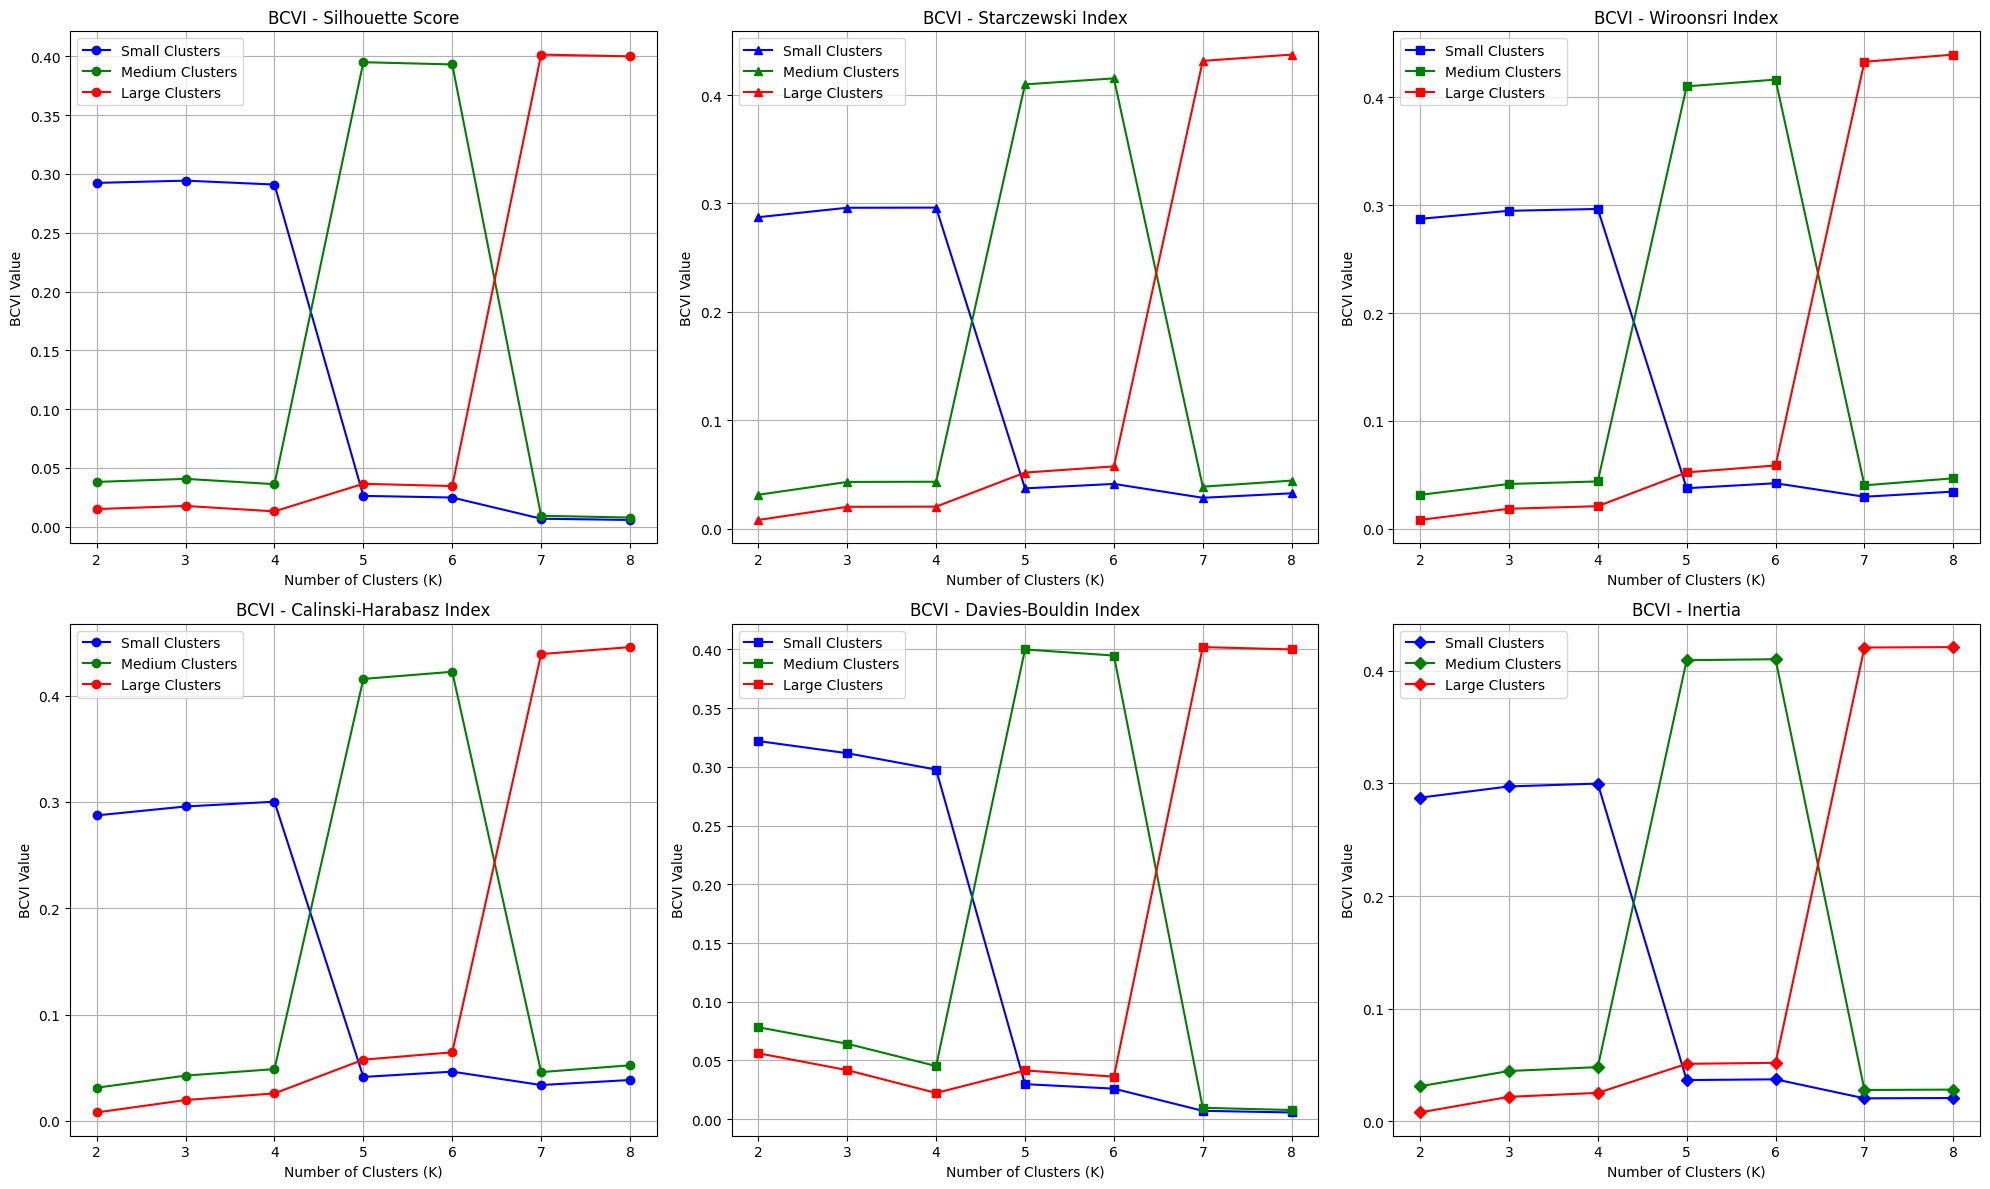

In [20]:
# Tạo subplot với 2 hàng và 3 cột
fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# Silhouette Score BCVI Plot
axs[0, 0].plot(K_values, bcvi_results["Silhouette Score"]["Small Clusters"], label="Small Clusters", marker='o', color='blue')
axs[0, 0].plot(K_values, bcvi_results["Silhouette Score"]["Medium Clusters"], label="Medium Clusters", marker='o', color='green')
axs[0, 0].plot(K_values, bcvi_results["Silhouette Score"]["Large Clusters"], label="Large Clusters", marker='o', color='red')
axs[0, 0].set_title("BCVI - Silhouette Score")
axs[0, 0].set_xlabel("Number of Clusters (K)")
axs[0, 0].set_ylabel("BCVI Value")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Starczewski Index BCVI Plot
axs[0, 1].plot(K_values, bcvi_results["Starczewski Index"]["Small Clusters"], label="Small Clusters", marker='^', color='blue')
axs[0, 1].plot(K_values, bcvi_results["Starczewski Index"]["Medium Clusters"], label="Medium Clusters", marker='^', color='green')
axs[0, 1].plot(K_values, bcvi_results["Starczewski Index"]["Large Clusters"], label="Large Clusters", marker='^', color='red')
axs[0, 1].set_title("BCVI - Starczewski Index")
axs[0, 1].set_xlabel("Number of Clusters (K)")
axs[0, 1].set_ylabel("BCVI Value")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Wiroonsri Index BCVI Plot
axs[0, 2].plot(K_values, bcvi_results["Wiroonsri Index"]["Small Clusters"], label="Small Clusters", marker='s', color='blue')
axs[0, 2].plot(K_values, bcvi_results["Wiroonsri Index"]["Medium Clusters"], label="Medium Clusters", marker='s', color='green')
axs[0, 2].plot(K_values, bcvi_results["Wiroonsri Index"]["Large Clusters"], label="Large Clusters", marker='s', color='red')
axs[0, 2].set_title("BCVI - Wiroonsri Index")
axs[0, 2].set_xlabel("Number of Clusters (K)")
axs[0, 2].set_ylabel("BCVI Value")
axs[0, 2].legend()
axs[0, 2].grid(True)

# Calinski-Harabasz Index BCVI Plot
axs[1, 0].plot(K_values, bcvi_results["Calinski-Harabasz Index"]["Small Clusters"], label="Small Clusters", marker='o', color='blue')
axs[1, 0].plot(K_values, bcvi_results["Calinski-Harabasz Index"]["Medium Clusters"], label="Medium Clusters", marker='o', color='green')
axs[1, 0].plot(K_values, bcvi_results["Calinski-Harabasz Index"]["Large Clusters"], label="Large Clusters", marker='o', color='red')
axs[1, 0].set_title("BCVI - Calinski-Harabasz Index")
axs[1, 0].set_xlabel("Number of Clusters (K)")
axs[1, 0].set_ylabel("BCVI Value")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Davies-Bouldin Index BCVI Plot
axs[1, 1].plot(K_values, bcvi_results["Davies-Bouldin Index"]["Small Clusters"], label="Small Clusters", marker='s', color='blue')
axs[1, 1].plot(K_values, bcvi_results["Davies-Bouldin Index"]["Medium Clusters"], label="Medium Clusters", marker='s', color='green')
axs[1, 1].plot(K_values, bcvi_results["Davies-Bouldin Index"]["Large Clusters"], label="Large Clusters", marker='s', color='red')
axs[1, 1].set_title("BCVI - Davies-Bouldin Index")
axs[1, 1].set_xlabel("Number of Clusters (K)")
axs[1, 1].set_ylabel("BCVI Value")
axs[1, 1].legend()
axs[1, 1].grid(True)

# Inertia BCVI Plot
axs[1, 2].plot(K_values, bcvi_results["Inertia"]["Small Clusters"], label="Small Clusters", marker='D', color='blue')
axs[1, 2].plot(K_values, bcvi_results["Inertia"]["Medium Clusters"], label="Medium Clusters", marker='D', color='green')
axs[1, 2].plot(K_values, bcvi_results["Inertia"]["Large Clusters"], label="Large Clusters", marker='D', color='red')
axs[1, 2].set_title("BCVI - Inertia")
axs[1, 2].set_xlabel("Number of Clusters (K)")
axs[1, 2].set_ylabel("BCVI Value")
axs[1, 2].legend()
axs[1, 2].grid(True)

plt.tight_layout()
plt.show()


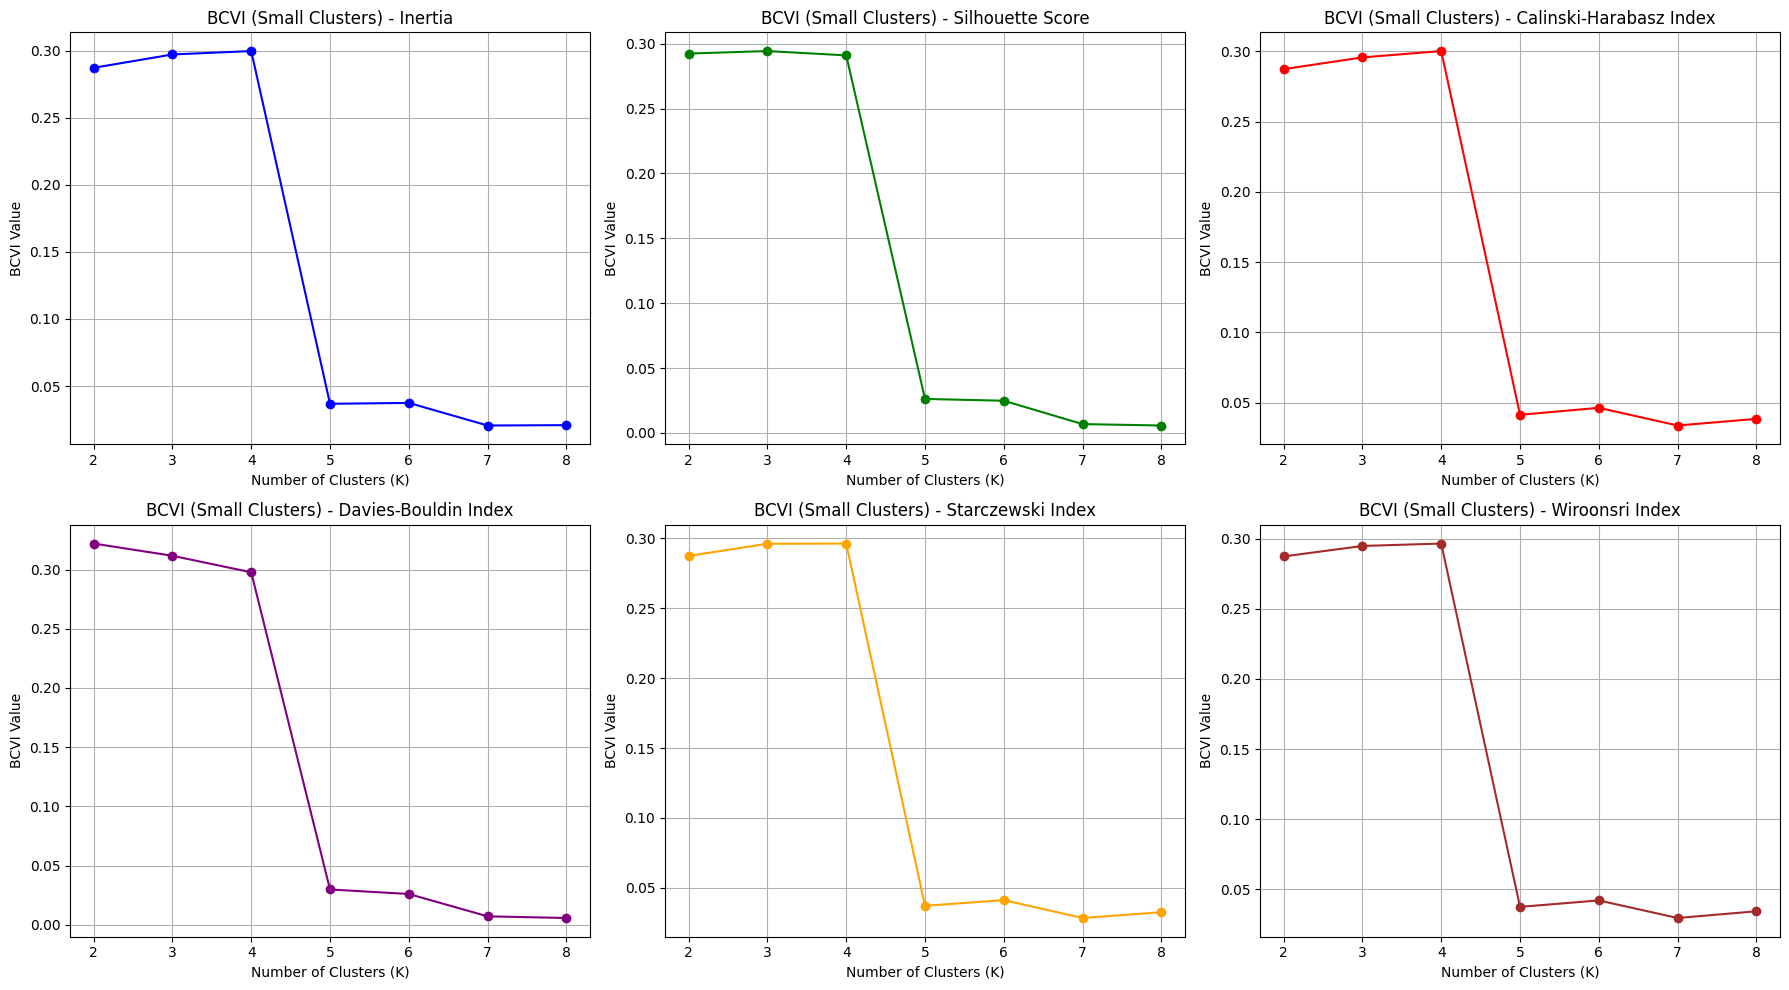

In [21]:
# Chuẩn bị dữ liệu cho đồ thị BCVI với alpha small clusters
bcvi_inertia = bcvi_results["Inertia"]["Small Clusters"]
bcvi_silhouette = bcvi_results["Silhouette Score"]["Small Clusters"]
bcvi_calinski = bcvi_results["Calinski-Harabasz Index"]["Small Clusters"]
bcvi_davies = bcvi_results["Davies-Bouldin Index"]["Small Clusters"]
bcvi_starczewski = bcvi_results["Starczewski Index"]["Small Clusters"]
bcvi_wiroonsri = bcvi_results["Wiroonsri Index"]["Small Clusters"]

# Tạo subplot với 2 hàng và 3 cột
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Inertia BCVI Plot
axs[0, 0].plot(K_values, bcvi_inertia, marker='o', color='blue')
axs[0, 0].set_title('BCVI (Small Clusters) - Inertia')
axs[0, 0].set_xlabel('Number of Clusters (K)')
axs[0, 0].set_ylabel('BCVI Value')
axs[0, 0].grid(True)

# Silhouette Score BCVI Plot
axs[0, 1].plot(K_values, bcvi_silhouette, marker='o', color='green')
axs[0, 1].set_title('BCVI (Small Clusters) - Silhouette Score')
axs[0, 1].set_xlabel('Number of Clusters (K)')
axs[0, 1].set_ylabel('BCVI Value')
axs[0, 1].grid(True)

# Calinski-Harabasz Index BCVI Plot
axs[0, 2].plot(K_values, bcvi_calinski, marker='o', color='red')
axs[0, 2].set_title('BCVI (Small Clusters) - Calinski-Harabasz Index')
axs[0, 2].set_xlabel('Number of Clusters (K)')
axs[0, 2].set_ylabel('BCVI Value')
axs[0, 2].grid(True)

# Davies-Bouldin Index BCVI Plot
axs[1, 0].plot(K_values, bcvi_davies, marker='o', color='purple')
axs[1, 0].set_title('BCVI (Small Clusters) - Davies-Bouldin Index')
axs[1, 0].set_xlabel('Number of Clusters (K)')
axs[1, 0].set_ylabel('BCVI Value')
axs[1, 0].grid(True)

# Starczewski Index BCVI Plot
axs[1, 1].plot(K_values, bcvi_starczewski, marker='o', color='orange')
axs[1, 1].set_title('BCVI (Small Clusters) - Starczewski Index')
axs[1, 1].set_xlabel('Number of Clusters (K)')
axs[1, 1].set_ylabel('BCVI Value')
axs[1, 1].grid(True)

# Wiroonsri Index BCVI Plot
axs[1, 2].plot(K_values, bcvi_wiroonsri, marker='o', color='brown')
axs[1, 2].set_title('BCVI (Small Clusters) - Wiroonsri Index')
axs[1, 2].set_xlabel('Number of Clusters (K)')
axs[1, 2].set_ylabel('BCVI Value')
axs[1, 2].grid(True)

plt.tight_layout()
plt.show()
